<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/classica/classificacaoNoticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
from multiprocessing import Pool, Process
import multiprocessing as mp
from google.colab import files, drive
from pathlib import Path
import io, os
import pickle
import pyarrow.parquet as pq
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)



import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from scipy.stats import uniform, randint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline


from sklearn import feature_selection
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, confusion_matrix, \
                            plot_confusion_matrix, classification_report, \
                            balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef, \
                            auc, roc_curve, precision_recall_curve

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [2]:
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/
!ls -lh 


Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks
total 40M
drwx------ 2 root root 4.0K Aug 31 12:22  amostra_news_integrada
drwx------ 2 root root 4.0K Aug 30 22:59  bertimbau
drwx------ 2 root root 4.0K Aug  7 13:00  bertimbau_resp
drwx------ 2 root root 4.0K Sep  1 13:17  classica_resp
-rw------- 1 root root 125K Sep  6 10:58  classificacaoNoticiasW2vec
drwx------ 2 root root 4.0K Nov  4 00:31  constrative
-rw------- 1 root root 2.5M Dec  5 17:57 'Cópia de Untitled5.ipynb'
drwx------ 2 root root 4.0K Aug 16 22:40  figuras
drwx------ 2 root root 4.0K Nov 20 19:45  models
-rw------- 1 root root 293K Dec  1 22:47  RNAP_Avaliacao_Final_v1.ipynb
-rw------- 1 root root  37M Nov 30 22:08  smartphone_activity_dataset.csv
drwx------ 2 root root 4.0K Sep 21 00:05  ulmfit_resp
-rw------- 1 root root  306 Jul 12 18:08  Untitled


In [4]:
%cd /gdrive/My\ Drive/Colab\ Notebooks/
!ls ./amostra_news_integrada/amostra_5


/gdrive/My Drive/Colab Notebooks
amostra5.zip  test.csv	train.csv  valid.csv


In [ ]:
mp.cpu_count()

2

# Funções para processamento de Linguagem Natural

In [6]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def aplicaLemmatization( texto):
  ''' obtém o radical das palavras do vocabulário'''
  lemm = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))


def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, n_grams=(1,1), excluirSW:list=None, vetorPalavras=None, n_top=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  if vetorPalavras==None:
    count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams, max_features=n_top) 
  else:
    count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams, vocabulary=vetorPalavras, max_features=n_top)
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X).vocabulary_
  return [matriz_sparsa,vocabulario]

def retornaMatriztfIdf(V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def reduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    data_pca= PCA(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X)
    X_pca =  UT.fit_transform(X)
      
    return [UT,X_pca]

def padronizaValores(X):
  X_norm = StandardScaler(with_mean=False).fit_transform(X)
  return X_norm

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int, sw=None):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10, stopwords = sw).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None, sw=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras, sw)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()

def preProcessaTextos(dfDados):
  download_pt_stopWords()
  dfDados['text'] = dfDados['text'].astype('unicode')
  dfDados['text'] = dfDados['text'].map(removeCaracteresNaoDesejados)
  dfDados['text'] = dfDados['text'].map(removeStopWords)
  dfDados['text'] = dfDados['text'].map(aplicaStemming)
  return dfDados
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeCaracteresNaoDesejados(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeStopWords(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: aplicaStemming(x['text']),axis=1)

def PreProcessamentoParalelo(df, n_jobs):
  df_split = np.array_split(df,n_jobs)
  pool = Pool(n_jobs)
  resultado = pool.map(preProcessaTextos, df_split)
  df = pd.concat(resultado, sort=False)
  return df

def processaVetorizacao(dfDados,min_fr=0.01, max_fr=0.7, ngrams=(1,1),n_top=None, localDestinoVocabulario=None, vocabulario=None):
  arquivoVetores = 'count_vector.pkl'
  if vocabulario != None:
    vetorPalavras=vocabulario
  elif localDestinoVocabulario==None or Path(localDestinoVocabulario+"/"+arquivoVetores).is_file()==False:
    vetorPalavras=None
  else:
    vetorPalavras = carregaEstrutura(localDestinoVocabulario, arquivoVetores)
    if not vetorPalavras:
      vetorPalavras=None
  X = dfDados['text'].values
  vetores = retornaVetorizacao(X = X,pct_min = min_fr,pct_max = max_fr,n_grams = ngrams,vetorPalavras = vetorPalavras,n_top = n_top)
  if localDestinoVocabulario!=None:
    salvaEstrutura(vetores[1],localDestinoVocabulario,arquivoVetores)
  V = vetores[0]
  return vetores

def calcula_especificidade(matriz_confusao):
  FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
  FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
  VP = np.diag(matriz_confusao)
  VN = matriz_confusao.sum() - (FP + FN + VP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  VP = VP.astype(float)
  VN = VN.astype(float)
  TVN = np.sum(VN)/(np.sum(VN) + np.sum(FP))
  return TVN

def calcula_especificidade_porClasse(matriz_confusao):
  FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
  FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
  VP = np.diag(matriz_confusao)
  VN = matriz_confusao.sum() - (FP + FN + VP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  VP = VP.astype(float)
  VN = VN.astype(float)
  TVN = (VN)/(VN + FP)
  return TVN

def calcula_GMean_multiclass(revocacao):
   revoc = np.array(revocacao)
   GMean = revoc.prod()**(1.0/len(revoc))
   return GMean 

def elabora_relatorio_metricas(report, matriz_confusao):
  espec = calcula_especificidade_porClasse(matriz_confusao) # calcula o valor da especificidade para cada classe
  dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
  dfrep_a = dfrep[:-3].copy() # separa as métricas de cada classe do valor da acurácia geral do modelo
  dfrep_a['specificity'] = espec # inclui no dataframe o valor da especificidade
  dfrep_b  = dfrep[dfrep.index=='accuracy'].copy() #obtem do dataframe somente o valor da acurácia
  dfrep_b['specificity']=calcula_especificidade(matriz_confusao) # inclui o valor da especificidade geral de todas as classes
  metricas = ['precision', 'recall', 'specificity', 'f1-score', 'support'] #organiza as métricas na ordem desejada
  df = pd.concat([dfrep_a[metricas],dfrep_b[metricas]],sort=False) #concatena todos os valores em um único dataframe
  df['support'] = df['support'].astype('int')
  return df

def imprimeMetricas(y_pred, y_true, caminho_destino):
  relatorio = ""
  print('Classification Report:')
  n_classe = np.max(y_true)+1 #obtem o número de classes
  report = classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4, output_dict=True) #gera o relatório de métricas
  cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe)) #gera a matriz de confusao
  report = elabora_relatorio_metricas(report, cm) #inclui no relatorio a especificidade
  
  print(report)
  
  acuracia_score = accuracy_score(y_true, y_pred)
  cohen_kappa = cohen_kappa_score(y_true, y_pred,labels=np.arange(0,n_classe))
  ccmatheus = matthews_corrcoef(y_true, y_pred)
  Gmean = calcula_GMean_multiclass(report['recall'])
  acuracia_balanceada = balanced_accuracy_score(y_true, y_pred)
  precisao = precision_score(y_true, y_pred, average='macro')
  revocacao =  recall_score(y_true, y_pred, average='micro')

  #ax= plt.subplot()
  #sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

  #ax.set_title('Matriz de Confusão')

  #ax.set_xlabel('Predito')
  #ax.set_ylabel('Verdadeiro')
  dctGeral = {}
  dctGeral['acc'] = acuracia_score
  dctGeral['bal_acc'] = acuracia_balanceada
  dctGeral['ck']=cohen_kappa
  dctGeral['precisao'] = precisao
  dctGeral['revocacao'] = revocacao

  print("Acurácia:",acuracia_score)
  print('Acurácia balanceada:',acuracia_balanceada)
  print('GMean:', Gmean)
  print('Cohen Kappa Score:', cohen_kappa)
  print('Coef. Correlacao Matheus:', ccmatheus)
  
  y = caminho_destino.split('/')
  arquivo = y[-1:][0].split('.')[0]
  report.to_csv('/'.join(y[:-1]) + '/' + arquivo + ".csv", index=None)
  outrasMetricas  = "Acurácia:" + str(acuracia_score)
  outrasMetricas  += '\n Acurácia balanceada:' + str(acuracia_balanceada)
  outrasMetricas  += '\n GMean:' + str(Gmean)
  outrasMetricas  += '\n Cohen Kappa Score:' + str(cohen_kappa)
  outrasMetricas  += '\n Coef. Correlacao Matheus:' + str(ccmatheus)
  
  
  salvaEstrutura(outrasMetricas, '/'.join(y[:-1]), y[-1:][0])
  return [report, dctGeral]

def salvaEstrutura(estrutura, local, arquivo):
  print('***SALVANDO***')
  print(local + "/" + arquivo)
  pickle.dump(estrutura,open(local + "/" + arquivo,'wb'))

def carregaEstrutura(local, arquivo):
  estrutura = pickle.load(open(local + "/" + arquivo,'rb'))
  return estrutura

def imprimeROC_PrecisonRecall_curvas(y_teste,predicted_prob):
  classes = np.unique(y_teste)
  y_test_array = pd.get_dummies(y_teste, drop_first=False).values
  fig, ax = plt.subplots(figsize=(12,8),nrows=1, ncols=2)
  ## Plot roc
  for i in range(len(classes)):
      fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
      ax[0].plot(fpr, tpr, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                auc(fpr, tpr))
                )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='Taxa Falso Positivo ', 
            ylabel="Taxa Verdadeiro Positivo (Revocação)", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)

  ## Plot precision-recall curve
  for i in range(len(classes)):
      precision, recall, thresholds = precision_recall_curve(
                  y_test_array[:,i], predicted_prob[:,i])
      ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                    auc(recall, precision))
                )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()

# Prepara dataset para classificação com algoritmos clássicos

In [5]:
#dfDados = pd.read_csv('news_integradas.csv')
dfTreino = pd.read_csv('./amostra_news_integrada/amostra_5/train.csv')
dfvalidacao = pd.read_csv('./amostra_news_integrada/amostra_5/valid.csv')
dfteste = pd.read_csv('./amostra_news_integrada/amostra_5/test.csv')
dfteste = pd.concat([dfvalidacao, dfteste], sort=False)
print(dfTreino.shape, dfteste.shape)

(15396, 2) (3849, 2)


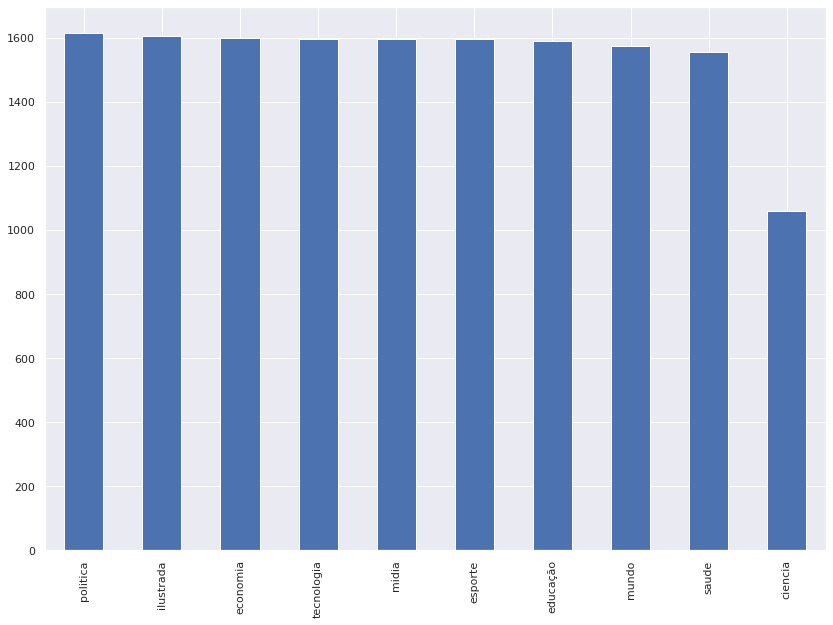

In [ ]:
def categoria(nro):
  cat = ['politica', 'economia', 'esporte', 'mundo', 'ilustrada', 'midia', 'tecnologia', 'educação', 'saude', 'ciencia']
  return cat[nro]
df = dfTreino.copy()
df['categoria'] = df['category_nro'].map(categoria)
dfv = df['categoria'].value_counts()
dfv.plot.bar(figsize=(14,10))


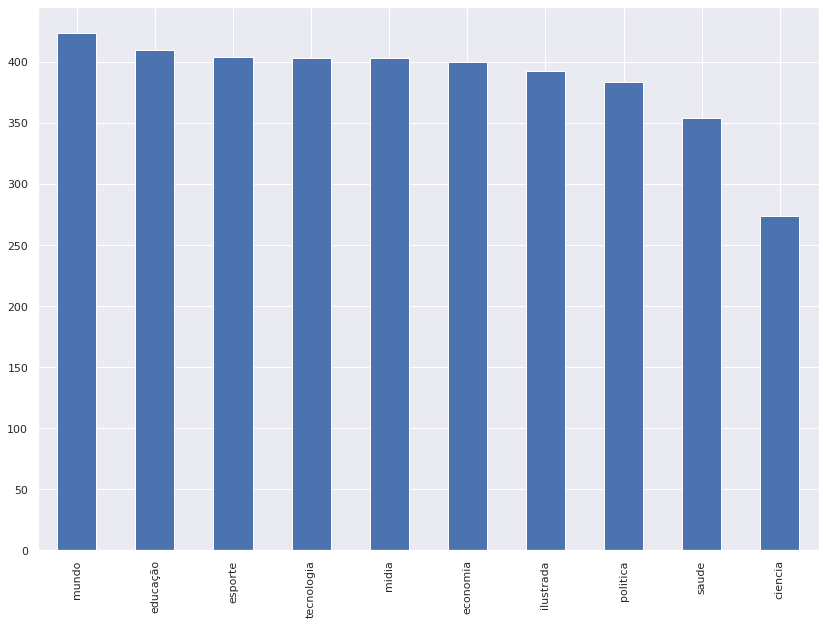

In [ ]:
df = dfteste.copy()
df['categoria'] = df['category_nro'].map(categoria)
dfv = df['categoria'].value_counts()
dfv.plot.bar(figsize=(14,10))

In [7]:
%%time
dfPreProc = PreProcessamentoParalelo(dfTreino,mp.cpu_count())
#dfPreProc = preProcessaTextos(dfTreino)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data]   Unzipping stemmers/rslp.zip.
CPU times: user 786 ms, sys: 224 ms, total: 1.01 s
Wall time: 2min 30s


In [ ]:
print(dfPreProc.shape)
dfPreProc.head()

(15396, 2)


,text,category_nro
0,pouc ano vinic lanz encontr reaç chor prov result decepç ent ano isolous vesti mergulh desol profund enquant lágr corr rost míser cinc cent jog rio dentr própri estádi aquá olímp pouc mes sedi megaevent espor exempl vid nat replet vir part dest terç lanz chanc promov trezent setent set dia após frustr sele olímp cheg troféu mar lenk prim grand event nat nacion cicl melhor temp entr m borbolet eliminatór final nest terç tornei parqu aquá mar lenk dentr parqu olímp classificatóri mund budap julh vai marc pass bast geraçesthiag per exempl aposentous abril enquant país vê surg nom lanz outr ter ido jog bom mant fog brig vag final medalh tóqui diz min hoj ano represent min tênil club medalh prat campeonat mund júni cingap m borbolet lanz adot eua bas iníci estabeleceus bloomington est indi ond pass nad univers local estud veterinár institu pass ser orient ray looz técn integr seleç norteameric rio guru lilly king cody mill blak pieron tod medalh jog nest tempor nad brasil eleit capitã tim universit ray diss vin quer olimpí agor olh pra frent cont nad vag budap dev corrobor técn diss perd olimpí cinc cent aind machuc fez mant foc mai mudanç atitud resum luiz altam viv experi difer consegu classific jog rio prov m livr revez x m livr pass prim fas ambas nad reconhec aprend pod ser interess rum olimpí tóqui obje agor nest cicl tent fic melhor mund precis trein bast natur rora transfer flameng pinh nest tempor club paulist divid rai gabriel sant jog rio nad revez x m livr pedr card perd olimpí pouc fic terc m peit boa marc pinh readquir ces ciel nad vitori histór país mud filosof dispens medalh olímp brun fratu joã lucc apost nov safr perceb hor mud mental afirm técn princip club albert pint silv outr bom val est troféu mar lenk brandonn alme nad m medley m livr rio dev mud eua compet fund guilherm cost abril bat record sulameric m livr esper estabelecers expo ger confi mar lenk consegu melhor temp vou mund diss cris cois abal confianç promess situ turbulent pass cbd confeder brasil desport aquá acus corrupç quatr dirig pres mei entidad perd patrocíni brad viu despenc aport feit correi invest vai diminu bast vai ser dificuldad grand nov ger busc nov competiç lá afirm luiz altam nad diss esper nov gest transpar melhor melhor man ter credibil nov mud tud pens estratég busc nov patrocin renov palavr cert complement altam viníc lanz acris abat sobr confeder trist vai afet ger sobr dirig pres afirm justiç decid event troféu mar lenk terçaf eliminatór h final h m borbolet feminin masculin m livr f m m peit f m x m livr f m quartaf eliminatór h final h m cost f m m medley f m m livr f m livr m quintaf eliminatór h final h m livr f m m peit fem m cost f m m borbolet f m sextaf eliminatór h final h m medley f m m livr f m m cost f m m borbolet f m x m livr f m sáb eliminatór h final h m peit f m m livr f m m livr f m livr m x m medley f m,2
1,situ financ paul apes restriç desp lig aument arrecad registr recent delic secret fazend luil arrob martim diz arrecad icm impost sobr circul mercad prim semestr dev ser ncr milh r bilh fic ncr milh r bilh qued além distanci previs orçamentár govern est reduz desej orç secret educ seguranç públic,6
2,document revel exag cia edward snowden mostr govern rein unid espion argentin obje mant soberan sobr ilh malvin document revel nest quintaf sit canal tv argentin tod notíc pertenc grup clarín segund papel argentin princip inter espion britân amér latin alv venezuel colômb prim document exib revel hav escritóri espion est tex eua ond coorden operaç amér sul document afirm emb argentin prior rein unid hav demand serviç intelig colômb venezuel informaç sobr motiv espion circul intern dat gchq quartel gener comunicaç govern britân sigl ingl report avanç obtenç informaç alt qual líd milit argentin document inform recolh comunicaç tetr sinal rádi us agênc governament seguranç públic emerg serviç milit sinal us ligaç celul tecnolog gsm segund tn entretant clar espion celul qual alv serviç intelig

In [12]:
dfPreProc_Teste = PreProcessamentoParalelo(dfteste,mp.cpu_count())
print(dfPreProc_Teste.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
(3849, 2)


In [13]:
 #df = dfPreProc.copy()
 dfPreProc['qtd_palavras'] = dfPreProc['text'].map(lambda x: len(x.split(" ")))
 dfPreProc['qtd_palavras'].describe()

count    15396.000000
mean       254.095934
std        188.458742
min          1.000000
25%        131.000000
50%        217.000000
75%        326.000000
max       2908.000000
Name: qtd_palavras, dtype: float64

In [14]:
#df[(df['qtd_palavras']>=0) & (df['qtd_palavras']<=10)]
dfPreProc = dfPreProc[dfPreProc['qtd_palavras']>10]

In [ ]:
df = dfTreino.copy()
df['qtd_palavras'] = df['text'].map(lambda x: len(x.split(" ")))
df['categoria'] = df['category_nro'].map(categoria)
df['qtd_palavras'].describe()

count    15396.000000
mean       463.567615
std        350.126359
min          1.000000
25%        236.000000
50%        394.000000
75%        596.000000
max       5190.000000
Name: qtd_palavras, dtype: float64

In [ ]:
df[(df['qtd_palavras']>=1) & (df['qtd_palavras']<=10)]

,text,category_nro,qtd_palavras,categoria
605,Os BBBs que foram trabalhar na TV após o reality,5,10,midia
637,Leia: http://folha.com/no1660675,5,2,midia
1935,O,5,1,midia
2049,Leia a reportagem,5,3,midia
2107,"Caso não consiga ler, ouça o que está escrito.",5,9,midia
2371,O,5,1,midia
3623,Leia a reportagem,5,3,midia
4684,Leia mais,5,2,midia
4782,Leia a reportagem aqui,5,4,midia
5241,Uma publicação compartilhada por Boninho (@jbboninho)\n,5,6,midia


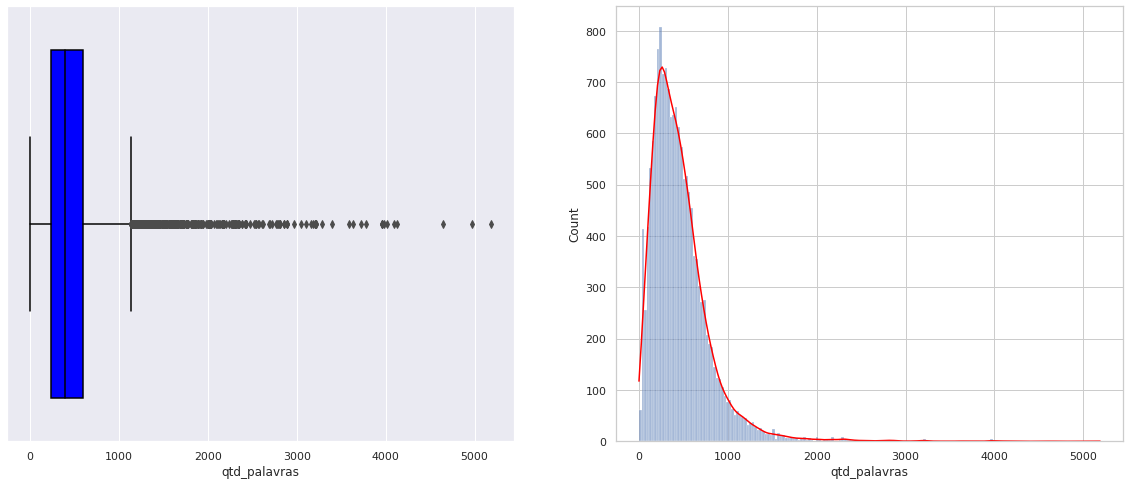

In [ ]:
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(1,2,1)
sns.set_theme(style="whitegrid")
sns.color_palette("Paired")
ax = sns.boxplot(x=df['qtd_palavras'])
mybox = ax.artists[0]
mybox.set_facecolor('blue')
mybox.set_edgecolor('black')
for line in ax.get_lines():
    line.set_color('black')
    
ax = fig.add_subplot(1,2,2)
ax = sns.histplot(data=df, x='qtd_palavras', kde=True)
for line in ax.get_lines():
    line.set_color('red')

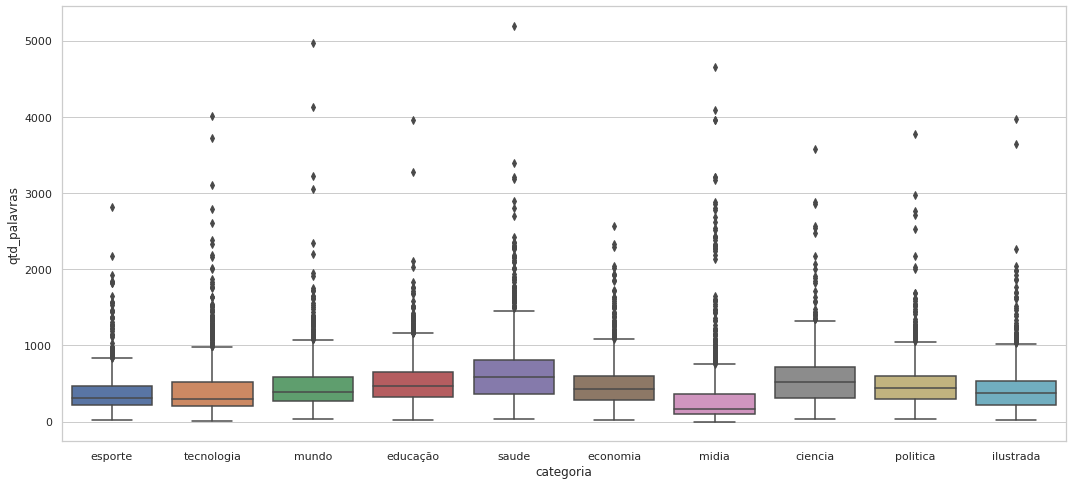

In [ ]:
fig = plt.figure(figsize = (18,8))
ax = sns.boxplot(x="categoria", y="qtd_palavras", data=df)

In [ ]:
V, vocab = processaVetorizacao(dfTreino,min_fr=1, max_fr=1, ngrams=(1,1),n_top=2100000)

In [ ]:
print(V.shape, len(vocab))

(15396, 52300) 52300


In [8]:
V, vocab = processaVetorizacao(dfPreProc,min_fr=1, max_fr=1, ngrams=(1,2),n_top=10000)
X_tfidf = retornaMatriztfIdf(V)
y_treino = dfPreProc['category_nro'].values

In [ ]:
V.shape

(15361, 10000)

In [ ]:
#https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
#teste chi2 para as palavras de cada categoria, manter as mais relevantes
X_names = list(vocab.keys())
y=dfPreProc['category_nro']
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_tfidf, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [ ]:
len(X_names)

6222

In [15]:
#reprocessa a vetorização e o tfidf para considerar somente o vocabulario de palavras relevantes.
#0.01 e 0.98
V, vocab = processaVetorizacao(dfPreProc,min_fr=0.01, max_fr=0.98, ngrams=(1,2),vocabulario=None)
X_tfidf = retornaMatriztfIdf(V)
y_treino = dfPreProc['category_nro'].values

In [10]:
X_tfidf.shape

(15396, 3002)

In [ ]:
#v_1_98 = vocab.keys()
#v_1_98_11 = vocab.keys()
#len(set(v_1_98) - set(v_1_98_11))

In [16]:
V, vocab = processaVetorizacao(dfPreProc_Teste,min_fr=1, max_fr=1, ngrams=(1,2),vocabulario=vocab)
X_tfidf_teste = retornaMatriztfIdf(V)
y_teste = dfPreProc_Teste['category_nro'].values

In [ ]:
X_tfidf_teste.shape

(3849, 3002)

## Naive-Bayes

In [17]:
#framePorClasse=[]
#frameGeral=[]
#pp=[]
#for i in range(0,10):
nb_classifier = MultinomialNB()
nb_classifier.fit(X_tfidf, y_treino)
y_pred_nb = nb_classifier.predict(X_tfidf_teste)
predicted_prob = nb_classifier.predict_proba(X_tfidf_teste)
df, geral = imprimeMetricas(y_pred_nb, y_teste,'./classica_resp/nb_v1.scr')
#framePorClasse.append(df)
#frameGeral.append(pd.DataFrame.from_dict(geral, orient='index').T)
#pp.append(predicted_prob)

Classification Report:
          precision    recall  specificity  f1-score  support
0          0.717949  0.875000     0.961905  0.788732      384
1          0.773684  0.735000     0.975065  0.753846      400
2          0.923469  0.896040     0.991292  0.909548      404
3          0.859813  0.867925     0.982482  0.863850      424
4          0.756356  0.908397     0.966725  0.825434      393
5          0.917695  0.553350     0.994196  0.690402      403
6          0.794189  0.813896     0.975334  0.803922      403
7          0.920863  0.936585     0.990404  0.928658      410
8          0.832021  0.895480     0.981688  0.862585      354
9          0.839216  0.781022     0.988531  0.809074      274
accuracy   0.826968  0.826968     0.980774  0.826968        0
Acurácia: 0.8269680436477007
Acurácia balanceada: 0.8262694226047984
GMean: 0.8187568045027335
Cohen Kappa Score: 0.8075163442616957
Coef. Correlacao Matheus: 0.8087528815797629
***SALVANDO***
./classica_resp/nb_v1.scr


In [18]:
geral

{'acc': 0.8269680436477007,
 'bal_acc': 0.8262694226047984,
 'ck': 0.8075163442616957,
 'precisao': 0.8335255660784533,
 'revocacao': 0.8269680436477007}

In [ ]:
cat = [categoria(i) for i in range(0,10)]
cat.append('acurácia')
df['categoria'] = cat
df['precision'] = pd.Series([" & ${0:.2f}\%$  ".format(val * 100) for val in df['precision']], index = df.index)
df['recall'] = pd.Series([" & ${0:.2f}\%$  ".format(val * 100) for val in df['recall']], index = df.index)
df['specificity'] = pd.Series([" & ${0:.2f}\%$  $".format(val * 100) for val in df['specificity']], index = df.index)
df['f1-score'] = pd.Series([" & ${0:.2f}\%$  & ".format(val * 100) for val in df['f1-score']], index = df.index)
df[['categoria', 'precision', 'recall', 'specificity','f1-score','support']]



,categoria,precision,recall,specificity,f1-score,support
0,politica,& $71.79\%$,& $87.50\%$,& $96.19\%$ $,& $78.87\%$ &,384
1,economia,& $77.37\%$,& $73.50\%$,& $97.51\%$ $,& $75.38\%$ &,400
2,esporte,& $92.35\%$,& $89.60\%$,& $99.13\%$ $,& $90.95\%$ &,404
3,mundo,& $85.98\%$,& $86.79\%$,& $98.25\%$ $,& $86.38\%$ &,424
4,ilustrada,& $75.64\%$,& $90.84\%$,& $96.67\%$ $,& $82.54\%$ &,393
5,midia,& $91.77\%$,& $55.33\%$,& $99.42\%$ $,& $69.04\%$ &,403
6,tecnologia,& $79.42\%$,& $81.39\%$,& $97.53\%$ $,& $80.39\%$ &,403
7,educação,& $92.09\%$,& $93.66\%$,& $99.04\%$ $,& $92.87\%$ &,410
8,saude,& $83.20\%$,& $89.55\%$,& $98.17\%$ $,& $86.26\%$ &,354
9,ciencia,& $83.92\%$,& $78.10\%$,& $98.85\%$ $,& $80.91\%$ &,274


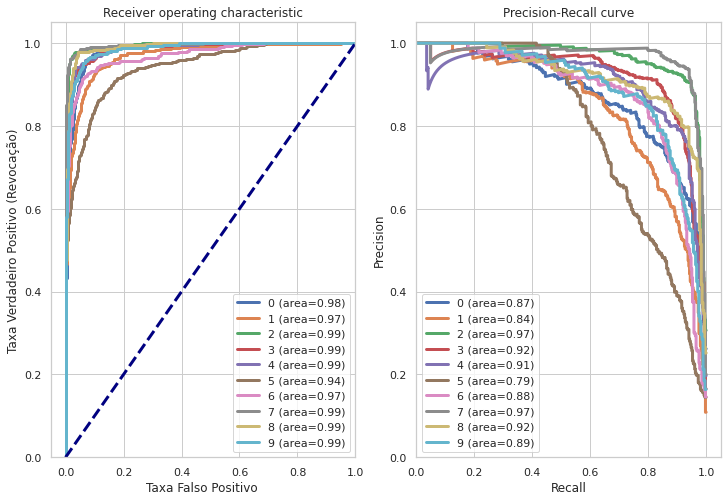

In [ ]:
imprimeROC_PrecisonRecall_curvas(y_teste, predicted_prob )

## RANDOM FOREST

Number of Estimators: 1 Accuracy: 0.5645622239542738
Number of Estimators: 11 Accuracy: 0.7739672642244739
Number of Estimators: 21 Accuracy: 0.8077422707196674
Number of Estimators: 31 Accuracy: 0.8118991945959989
Number of Estimators: 41 Accuracy: 0.8204728500909327
Number of Estimators: 51 Accuracy: 0.8222915042868277
Number of Estimators: 61 Accuracy: 0.82670823590543
Number of Estimators: 71 Accuracy: 0.8287866978435957
Number of Estimators: 81 Accuracy: 0.8300857365549493
Number of Estimators: 91 Accuracy: 0.8303455442972201
Melhor n: 91  com acurácia: 0.8303455442972201


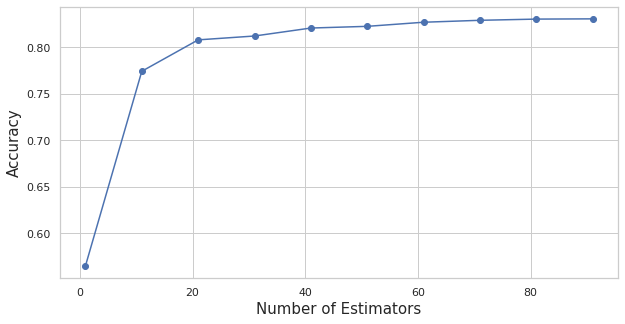

In [ ]:
'''Número de árvores que influencia o resultado'''

vscore = []
vn = []
for n in range(1,100,10):
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_tfidf,y_treino)
    y_pred = model.predict(X_tfidf_teste) 
    score = accuracy_score(y_pred, y_teste)
    print('Number of Estimators:', n, 'Accuracy:', score)
    vscore.append(score)
    vn.append(n)
best_n = vn[np.argmax(vscore)]
print('Melhor n:', best_n, ' com acurácia:', vscore[np.argmax(vscore)] )
plt.figure(figsize=(10,5))
plt.plot(vn, vscore, '-bo')
plt.xlabel('Number of Estimators', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()

In [ ]:
kf = KFold(20, random_state=42, shuffle=True)
accs = cross_val_score(
    RandomForestClassifier(
        random_state=42,
        n_estimators=best_n
    ),
    X=X_tfidf,
    y=y_treino,
    cv=kf,
    scoring="accuracy"
)

In [ ]:
np.mean(accs)


0.8303503941807542

In [ ]:
accs

array([0.81794538, 0.8203125 , 0.82942708, 0.82942708, 0.8359375 ,
       0.82161458, 0.81510417, 0.85026042, 0.81510417, 0.85546875,
       0.80989583, 0.84375   , 0.81640625, 0.85807292, 0.84375   ,
       0.8125    , 0.85026042, 0.83984375, 0.81901042, 0.82291667])

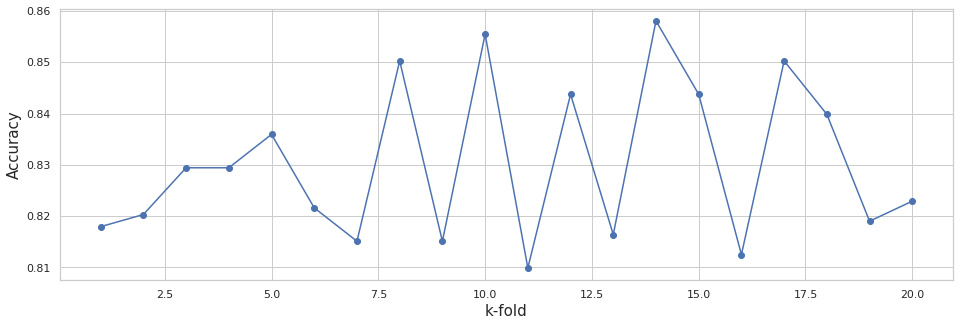

In [ ]:
k = [i for i in range(1,21)]
plt.figure(figsize=(16,5))
plt.plot(k, accs.tolist(), '-bo')
plt.xlabel('k-fold', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=91,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [22]:
framePorClasse=[]
frameGeral=[]
pp=[]
#for i in range(0,10):
model = RandomForestClassifier(n_estimators=best_n, 
                                random_state=120)
model.fit(X_tfidf, y_treino)
y_pred_rf = model.predict(X_tfidf_teste)
pred_prob = model.predict_proba(X_tfidf_teste)
df, geral = imprimeMetricas(y_pred_rf, y_teste,'./classica_resp/nb_v1.scr')
#framePorClasse.append(df)
#frameGeral.append(pd.DataFrame.from_dict(geral, orient='index').T)
#pp.append(predicted_prob)

Classification Report:
          precision    recall  specificity  f1-score  support
0          0.755245  0.843750     0.969697  0.797048      384
1          0.773087  0.732500     0.975065  0.752246      400
2          0.891705  0.957921     0.986357  0.923628      404
3          0.827338  0.813679     0.978978  0.820452      424
4          0.830508  0.872774     0.979745  0.851117      393
5          0.862170  0.729529     0.986361  0.790323      403
6          0.813896  0.813896     0.978236  0.813896      403
7          0.904872  0.951220     0.988078  0.927467      410
8          0.784264  0.872881     0.975680  0.826203      354
9          0.850962  0.645985     0.991329  0.734440      274
accuracy   0.828787  0.828787     0.980976  0.828787        0
Acurácia: 0.8287866978435957
Acurácia balanceada: 0.8234134161462945
GMean: 0.8188449368373422
Cohen Kappa Score: 0.8094440223207839
Coef. Correlacao Matheus: 0.8098719861874945
***SALVANDO***
./classica_resp/nb_v1.scr


In [23]:
geral

{'acc': 0.8287866978435957,
 'bal_acc': 0.8234134161462945,
 'ck': 0.8094440223207839,
 'precisao': 0.82940472569398,
 'revocacao': 0.8287866978435957}

Classification Report:
          precision    recall  specificity  f1-score  support
0          0.758065  0.856771     0.969697  0.804401      384
1          0.792350  0.725000     0.977965  0.757180      400
2          0.895833  0.957921     0.986938  0.925837      404
3          0.850856  0.820755     0.982190  0.835534      424
4          0.812950  0.862595     0.977431  0.837037      393
5          0.848397  0.722084     0.984910  0.780161      403
6          0.811558  0.801489     0.978236  0.806492      403
7          0.899543  0.960976     0.987206  0.929245      410
8          0.786802  0.875706     0.975966  0.828877      354
9          0.848624  0.675182     0.990769  0.752033      274
accuracy   0.830346  0.830346     0.981150  0.830346        0
Acurácia: 0.8303455442972201
Acurácia balanceada: 0.8258479269430745
GMean: 0.8215181955649711
Cohen Kappa Score: 0.8112003529913107
Coef. Correlacao Matheus: 0.811639188386592
***SALVANDO***
./classica_resp/rf_v1.scr


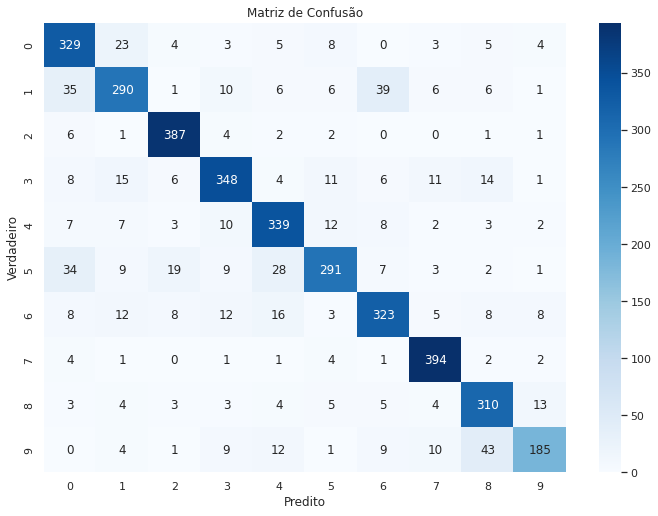

In [ ]:
dfrf = imprimeMetricas(y_pred_rf, y_teste,'./classica_resp/rf_v1.scr')


In [ ]:
cat = [categoria(i) for i in range(0,10)]
cat.append('acurácia')
dfrf['categoria'] = cat
dfrf['precision'] = pd.Series([" & ${0:.2f}\%$  ".format(val * 100) for val in dfrf['precision']], index = df.index)
dfrf['recall'] = pd.Series([" & ${0:.2f}\%$  ".format(val * 100) for val in dfrf['recall']], index = df.index)
dfrf['specificity'] = pd.Series([" & ${0:.2f}\%$ ".format(val * 100) for val in dfrf['specificity']], index = df.index)
dfrf['f1-score'] = pd.Series([" & ${0:.2f}\%$  & ".format(val * 100) for val in dfrf['f1-score']], index = df.index)
dfrf[['categoria', 'precision', 'recall', 'specificity','f1-score','support']]


,categoria,precision,recall,specificity,f1-score,support
0,politica,& $75.81\%$,& $85.68\%$,& $96.97\%$,& $80.44\%$ &,384
1,economia,& $79.23\%$,& $72.50\%$,& $97.80\%$,& $75.72\%$ &,400
2,esporte,& $89.58\%$,& $95.79\%$,& $98.69\%$,& $92.58\%$ &,404
3,mundo,& $85.09\%$,& $82.08\%$,& $98.22\%$,& $83.55\%$ &,424
4,ilustrada,& $81.29\%$,& $86.26\%$,& $97.74\%$,& $83.70\%$ &,393
5,midia,& $84.84\%$,& $72.21\%$,& $98.49\%$,& $78.02\%$ &,403
6,tecnologia,& $81.16\%$,& $80.15\%$,& $97.82\%$,& $80.65\%$ &,403
7,educação,& $89.95\%$,& $96.10\%$,& $98.72\%$,& $92.92\%$ &,410
8,saude,& $78.68\%$,& $87.57\%$,& $97.60\%$,& $82.89\%$ &,354
9,ciencia,& $84.86\%$,& $67.52\%$,& $99.08\%$,& $75.20\%$ &,274


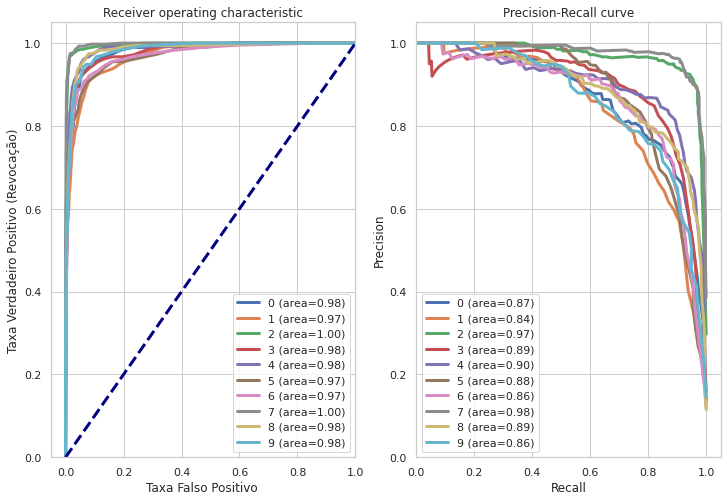

In [ ]:

imprimeROC_PrecisonRecall_curvas(y_teste, pred_prob )